# [INFO-H515 - Big Data Scalable Analytics](https://uv.ulb.ac.be/course/view.php?id=85246?username=guest)


## TP 1 - Introduction to Spark ML library: Churn prediction

*Notebook content adapted from https://github.com/bensadeghi/pyspark-churn-prediction*

*Materials originally developed by Yann-Aël Le Borgne, Jacopo De Stefani and Gianluca Bontempi*

#### *Theo Verhelst, Cedric Simar and Gianluca Bontempi*

####  29/03/2023

This class aims at providing an overview of the Spark framework for loading a dataset, performing some data exploration, and building prediction models using the [Spark MLlib (machine learning) library](https://spark.apache.org/docs/latest/ml-guide.html). 

Take a moment to check the content of the Spark MLlib library.

The case study is a churn prediction problem, which consists in minimizing customer defection by predicting which customers are likely to cancel a subscription to a service. Churn prediction is a crucial problem for many businesses. Originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals. Churn prediction is essentially a classification problem : Will a given customer quit or not?

Example of data that we will use:

![](./img/ExampleDataChurn.png)


### Class objectives:

* Subsample a Spark Dataframe for local visual/statistical exploration using Python Pandas
* Train a prediction model using Spark ML library
* Use pipelines to prepare datasets, and run cross validation
* Assess model performances using different accuracy metrics
* Make predictions on new data (not used during training)


# General imports

In [1]:
import os 

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd

# 1) Data loading and preliminary data exploration 

Let us first start a Spark session, load a dataset, and perform some preliminary data exploration using the Spark SQL and DataFrames modules. Additional examples of functions and uses of these modules can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html). 

#### Start Spark session

A Spark session is created by using the pyspark.sql.SparkSession object. See [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#starting-point-sparksession) for the API documentation on the SparkSession Object. 



In [2]:
#This is needed to start a Spark session from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=2g  pyspark-shell"

from pyspark.sql import SparkSession

**Exercise:**

Start Spark session with local master and 2 cores, and name it 'churnPrediction'
Use
```
spark = SparkSession \
    .builder \
...TOFILL
    .getOrCreate()
```


In [3]:
#Solution
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("churnPrediction") \
    .getOrCreate()

22/02/15 14:33:05 WARN Utils: Your hostname, PC-ACERE resolves to a loopback address: 127.0.1.1; using 192.168.0.2 instead (on interface wlp3s0)
22/02/15 14:33:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/15 14:33:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/15 14:33:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


You can now connect to the Spark user interface on port 4040 (IP:4040 in your browser. IP depends on your installation - 127.0.0.1 or other).

![](./img/spark_init.png)



Note: Use `spark.stop()` to stop the session.  

In [4]:
spark.stop()

#### Fetching and Importing Churn Data

For this class, we will be using the [Orange Telecoms Churn Dataset](http://www.kdd.org/kdd-cup/view/kdd-cup-2009). It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The data can be fetched from BigML's S3 bucket, [churn-80](https://bml-data.s3.amazonaws.com/churn-bigml-80.csv) and [churn-20](https://bml-data.s3.amazonaws.com/churn-bigml-20.csv). The two sets are from the same batch, but have been split by an 80/20 ratio. We'll use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation. The two data sets have been included in this repository for convenience.

Let us load the two CSV data sets into DataFrames, keeping the header information and caching them into memory for quick, repeated access. We will also print the schema of the sets.

In [4]:
#Load the ./data/churn-bigml-80.csv and store in CV_data
CV_data = spark.read.load('./data/churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

Check the Spark UI. Notice there are two jobs for loading the data. The first one was to infer the column types (only 2 records read). The second actually loads the data. 

**Exercise:**

Load the ./data/churn-bigml-20.csv and store in a variable final_test_data

In [5]:
#Solution
final_test_data = spark.read.load('./data/churn-bigml-20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')


**Exercise:**

Cache CV_data, and print its schema (use `cache` and `printSchema` functions).

In [6]:
#Solution
CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



**Exercise:**

Count the number of observsations in CV_data (use `count` function).

In [7]:
#Solution
CV_data.count()

2666

Check in the Spark UI that data was properly cached. See the storage tab. 

Let us take the first five rows of CV_data to see what they look like. 

In [8]:
CV_data.take(5)

[Row(State='KS', Account length=128, Area code=415, International plan='No', Voice mail plan='Yes', Number vmail messages=25, Total day minutes=265.1, Total day calls=110, Total day charge=45.07, Total eve minutes=197.4, Total eve calls=99, Total eve charge=16.78, Total night minutes=244.7, Total night calls=91, Total night charge=11.01, Total intl minutes=10.0, Total intl calls=3, Total intl charge=2.7, Customer service calls=1, Churn=False),
 Row(State='OH', Account length=107, Area code=415, International plan='No', Voice mail plan='Yes', Number vmail messages=26, Total day minutes=161.6, Total day calls=123, Total day charge=27.47, Total eve minutes=195.5, Total eve calls=103, Total eve charge=16.62, Total night minutes=254.4, Total night calls=103, Total night charge=11.45, Total intl minutes=13.7, Total intl calls=3, Total intl charge=3.7, Customer service calls=1, Churn=False),
 Row(State='NJ', Account length=137, Area code=415, International plan='No', Voice mail plan='No', Num

Let us use Pandas on top of Spark _take()_ function to get a prettier print.

In [9]:
pd.DataFrame(CV_data.take(50)[15:25], columns=CV_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,VA,76,510,No,Yes,33,189.7,66,32.25,212.8,65,18.09,165.7,108,7.46,10.0,5,2.70,1,False
1,TX,73,415,No,No,0,224.4,90,38.15,159.5,88,13.56,192.8,74,8.68,13.0,2,3.51,1,False
2,FL,147,415,No,No,0,155.1,117,26.37,239.7,93,20.37,208.8,133,9.40,10.6,4,2.86,0,False
3,CO,77,408,No,No,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,True
4,AZ,130,415,No,No,0,183.0,112,31.11,72.9,99,6.20,181.8,78,8.18,9.5,19,2.57,0,False
5,VA,132,510,No,No,0,81.1,86,13.79,245.2,72,20.84,237.0,115,10.67,10.3,2,2.78,0,False
6,NE,174,415,No,No,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,False
7,WY,57,408,No,Yes,39,213.0,115,36.21,191.1,112,16.24,182.7,115,8.22,9.5,3,2.57,0,False
8,MT,54,408,No,No,0,134.3,73,22.83,155.5,100,13.22,102.1,68,4.59,14.7,4,3.97,3,False
9,MO,20,415,No,No,0,190.0,109,32.30,258.2,84,21.95,181.5,102,8.17,6.3,6,1.70,0,False


#### Summary Statistics

Spark DataFrames include some [built-in functions](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) for statistical processing. The _describe()_ function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame. 

In [10]:
CV_data.describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64
Total eve minutes,2666,200.38615903976006,50.95151511764598,0.0,363.7


#### Correlations and Data Preparation

We can also perform our own statistical analyses, using the [ML statistics package](http://spark.apache.org/docs/2.2.0/ml-statistics.html) or other python packages. Here, we're use the Pandas library to examine correlations between the numeric columns by generating scatter plots of them.

For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. Instead, we randomly sample a portion of the data (say 10%) to get a rough idea of how it looks. 

Let us first select the numeric features:

In [11]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

**Exercise:**

* Select the numeric features from the CV_data dataframe (`select` function)
* Sample 10% of the dataframe without replacement (`sample` function)
* Convert the resulting Spark dataframe to a Panda dataframe (`toPandas` function), and store in a variable `sampled_data``

In [12]:
#Solution
sampled_data = CV_data.\
                select(numeric_features).\
                sample(False, 0.10).\
                toPandas()

And let us plot the correlations between features:

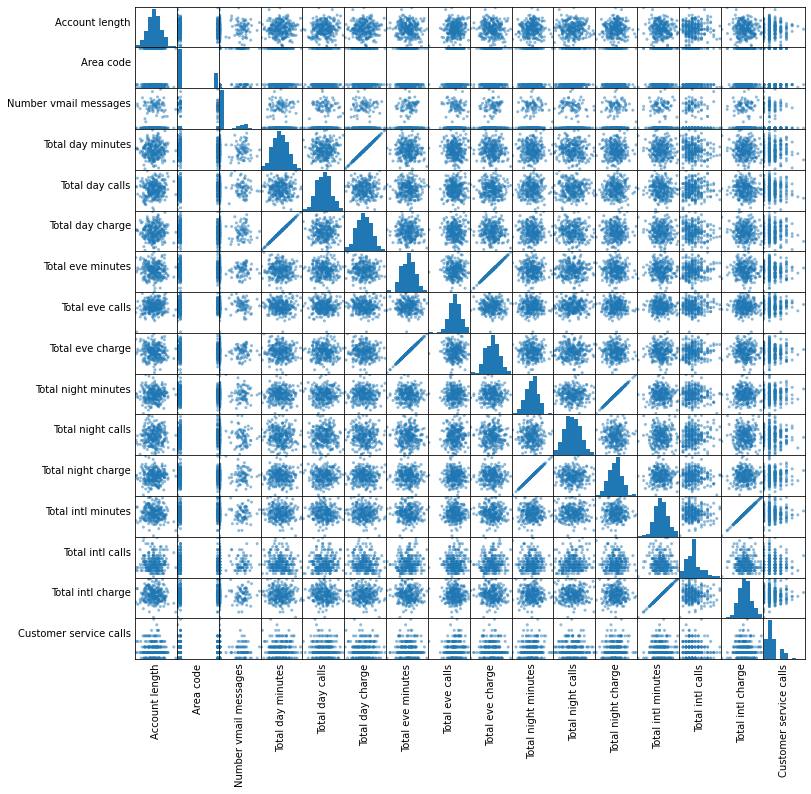

In [13]:
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It is obvious that there are several highly correlated fields, ie _Total day minutes_ and _Total day charge_. Such correlated data will not be very beneficial for our model training runs, so we are going to remove them. We will do so by dropping one column of each pair of correlated fields, along with the _State_ and _Area code_ columns. Dropping a column is done by using the `drop` function.



**Exercise:**

Remove the _State_ , _Area code_ , _Total day charge_ , _Total eve charge_ , _Total night charge_ and _Total intl charge_ variables from both CV_data and final_test_data dataframes.

In [14]:
#Solution
CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge')
    
final_test_data = final_test_data.drop('State','Area code','Total day charge','Total eve charge'\
                                       ,'Total night charge','Total intl charge')

While we are in the process of manipulating the data sets, let us transform the categorical data into numeric as required by the machine learning routines. Transforming columns in Spark is done using the [`withColumn`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) function, taking as parameter the name of the new column (or an existing one for transforming the content of an existing column), and the function used to generate the content of the new column.

The function used to generate the content of the new column must be a user-defined function (http://changhsinlee.com/pyspark-udf/). For example, to convert a column that contains Yes/No to 1 and 0, let us first create a function that makes this transformation, using a simple user-defined functions `transform1` that maps Yes/True and No/False to 1 and 0, respectively. 

Creating a new column is done by using the 

* Import `udf` from [pyspark.sql.function](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions)
* Write the user defined function `transform1`, and make it a `udf`
* Transform 

In [15]:
#Transforms 'Yes' and 'No' to '1.0' or '0.0'
def transform1(value):
    result=-1.0
    if value=='Yes':
        result=1.0
    if value=='No':
        result=0.0
    return result

Let us make it a user-defined function (udf)

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

transform1_udf = udf(lambda k: transform1(k), DoubleType())

And finally transform the column using the `withColumn' function:

In [17]:
CV_data = CV_data.withColumn('International plan', transform1_udf(CV_data['International plan'])) \
    .withColumn('Voice mail plan', transform1_udf(CV_data['Voice mail plan'])).cache()

Let us also do the transformation for `final_test_data`: 

In [18]:
final_test_data = final_test_data\
    .withColumn('International plan', transform1_udf(final_test_data['International plan']))\
    .withColumn('Voice mail plan', transform1_udf(final_test_data['Voice mail plan'])).cache()

**Exercise**

Transform the _Churn_ column (boolean) in a numeric feature (0.0 for False, 1.0 for True), by adapting the code above with two new functions `transform2` and `transform2_udf`, for both `CV_data` and `final_test_data`. 

In [19]:
#Solution

#Transforms 'Yes' and 'No' to '1.0' or '0.0'
def transform2(value):
    dic={False: 0.0, True:1.0}
    return dic[value]

transform2_udf= udf(lambda k: transform2(k), DoubleType())

CV_data=CV_data.withColumn('Churn', transform2_udf(CV_data['Churn'])).cache()
final_test_data = final_test_data.withColumn('Churn', transform2_udf(final_test_data['Churn'])).cache()

Let us take a quick look at the resulting data set.

In [20]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0.0,1.0,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0.0
1,107,0.0,1.0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0.0
2,137,0.0,0.0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0.0
3,84,1.0,0.0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0.0
4,75,1.0,0.0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0.0


# 2) Modelling using the Spark MLlib Package (RDD-based)

The RDD-based [MLlib package](http://spark.apache.org/docs/latest/mllib-guide.html) provides a variety of machine learning algorithms for classification, regression, cluster and dimensionality reduction, as well as utilities for model evaluation. The decision tree is a popular classification algorithm, and we'll be using it below.  

### Decision Tree Models

Decision trees have played a significant role in data mining and machine learning since the 1960's. They generate white-box classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

A decision tree is a predictive model which maps observations (features) about an item to conclusions about the item's label or class. The model is generated using a top-down approach, where the source dataset is split into subsets using a statistical measure, often in the form of the Gini index or information gain via Shannon entropy. This process is applied recursively until a subset contains only samples with the same target class, or is halted by a predefined stopping criteria.

### Model Training

RDD-based MLlib classifiers and regressors require data sets in a format of rows of type _LabeledPoint_ , which separates row labels and feature lists, and names them accordingly. The custom _labelData()_ function shown below performs the row parsing. We'll pass it the prepared data set (CV_data) and split it further into training and testing sets. A [decision tree classifier model](https://spark.apache.org/docs/2.1.1/mllib-decision-tree.html) is then generated using the training data, using a maxDepth of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity. 

In [21]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data.rdd).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

print(model.toDebugString())

DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 4 <= 262.55)
   If (feature 12 <= 3.5)
    Predict: 0.0
   Else (feature 12 > 3.5)
    Predict: 1.0
  Else (feature 4 > 262.55)
   If (feature 2 in {1.0})
    Predict: 0.0
   Else (feature 2 not in {1.0})
    Predict: 1.0



The _toDebugString()_ function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields _Customer service calls_ and _Total day minutes_. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

In [22]:
print('Feature 12:', CV_data.columns[12])
print('Feature 4: ', CV_data.columns[4])
print('Feature 2: ', CV_data.columns[2])

Feature 12: Customer service calls
Feature 4:  Total day minutes
Feature 2:  Voice mail plan


Below is the structure of a Labeled Point:

In [23]:
datapoint = training_data.take(1)[0]
print(datapoint.features) 
print(datapoint.label) 

[128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]
0.0


### Model Evaluation

Predictions of the testing data's churn outcome are made with the model's _predict()_ function and grouped together with the actual churn label of each customer data using _getPredictionsLabels()_.

We'll use MLlib's _MulticlassMetrics_ (https://spark.apache.org/docs/2.1.1/mllib-evaluation-metrics.html#binary-classification) for the model evaluation, which takes rows of (prediction, label) tuples as input. It provides metrics such as precision, recall, F1 score and confusion matrix, which have been bundled for printing with the custom _printMetrics()_ function.

In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True '+ str(metrics.precision(1)))
    print('Precision of False'+ str(metrics.precision(0)))
    print('Recall of True    '+ str(metrics.recall(1)))
    print('Recall of False   '+ str(metrics.recall(0)))
    print('F-1 Score         '+ str(metrics.fMeasure(1.0)))
    print('Confusion Matrix\n'+ str(metrics.confusionMatrix().toArray()))

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Precision of True 0.5714285714285714
Precision of False0.9212765957446809
Recall of True    0.5432098765432098
Recall of False   0.9291845493562232
F-1 Score         0.5569620253164557
Confusion Matrix
[[433.  33.]
 [ 37.  44.]]


The overall accuracy, ie F-1 score, seems quite good, but one troubling issue is the discrepancy between the recall measures. The recall (aka sensitivity) for the Churn=False samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the Churn=True samples.

Perhaps the model's sensitivity bias toward Churn=False samples is due to a skewed distribution of the two types of samples. Let's try grouping the CV_data DataFrame by the _Churn_ field and counting the number of instances in each group. 

In [25]:
CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,2278
1,1.0,388


### Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames _sampleBy()_ function does this when provided with fractions of each sample type to be returned.



**Exercise:**

Keep all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278. Put the resulting dataframe in a variable `stratified_CV_data`. Use the `sampleBy` function.

In [26]:
#Solution
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

**Exercise:**

Check the number of examples per class is balanced (use the `groupBy`/`count` as above)


In [27]:
#Solution
stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,397
1,1.0,388


**Exercise:**

Build a new model using the evenly distributed data set and see how it performs (adapt the code above).

In [28]:
training_data, testing_data = labelData(stratified_CV_data.rdd).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Precision of True 0.8653846153846154
Precision of False0.7102803738317757
Recall of True    0.5921052631578947
Recall of False   0.9156626506024096
F-1 Score         0.703125
Confusion Matrix
[[76.  7.]
 [31. 45.]]


With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

# 3) Modelling using the Spark ML Package (DataFrame based)

The Dataframe-based [MLlib package](http://spark.apache.org/docs/latest/ml-guide.html) is the newer library of machine learning routines. It provides an API for pipelining data transformers, estimators and model selectors. We'll use it here to perform cross-validation across several decision trees with various _maxDepth_ parameters in order to find the optimal model.

### Pipelining

The ML package needs data be put in a (label: Double, features: Vector) DataFrame format with correspondingly named fields. The _vectorizeData()_ function below performs this formatting.

Next we'll pass the data through a pipeline of two transformers, _StringIndexer()_ and _VectorIndexer()_ which index the label and features fields respectively. Indexing categorical features allows decision trees to treat categorical features appropriately, improving performance. The final element in our pipeline is an estimator (a decision tree classifier) training on the indexed labels and features.

### Model Selection

Given the data set at hand, we would like to determine which parameter values of the decision tree produce the best model. We need a systematic approach to quantitatively measure the performance of the models and ensure that the results are reliable. This task of model selection is often done using cross validation techniques. A common technique is k-fold cross validation, where the data is randomly split into k partitions. Each partition is used once as the testing data set, while the rest are used for training. Models are then generated using the training sets and evaluated with the testing sets, resulting in k model performance measurements. The average of the performance scores is often taken to be the overall score of the model, given its build parameters.

For model selection we can search through the model parameters, comparing their cross validation performances. The model parameters leading to the highest performance metric produce the best model.

The ML package supports k-fold cross validation, which can be readily coupled with a parameter grid builder and an evaluator to construct a model selection workflow. Below, we'll use a transformation/estimation pipeline to train our models. The cross validator will use the _ParamGridBuilder_ to iterate through the _maxDepth_ parameter of the decision tree and evaluate the models using the F1-score, repeating 3 times per parameter value for reliable results.

In [29]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def vectorizeData(data):
    return data.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

vectorized_CV_data = vectorizeData(stratified_CV_data.rdd)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorized_CV_data)

# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

# Fetch best model
tree_model = CV_model.bestModel.stages[2]
print(tree_model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_00f9256c308d, depth=5, numNodes=39, numClasses=2, numFeatures=13


We find that the best tree model produced using the cross-validation process is one with a depth of 5. So we can assume that our initial "shallow" tree of depth 2 in the previous section was not complex enough, while trees of depth higher than 5 overfit the data and will not perform well in practice.

### Predictions and Model Evaluation

The actual performance of the model can be determined using the final_test_data set which has not been used for any training or cross-validation activities. We'll transform the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluator will provide us with the F-1 score of the predictions, and then we'll print them along with their probabilities. Predictions on new, unlabeled customer activity data can also be made using the same pipeline CV_model._transform()_ function.

In [30]:
vectorized_test_data = vectorizeData(final_test_data.rdd)

transformed_data = CV_model.transform(vectorized_test_data)
print(evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.9297920923735034


,indexedLabel,prediction,probability
0,0.0,0.0,"[0.8579545454545454, 0.14204545454545456]"
1,1.0,1.0,"[0.022727272727272728, 0.9772727272727273]"
2,1.0,1.0,"[0.010638297872340425, 0.9893617021276596]"
3,0.0,0.0,"[0.8579545454545454, 0.14204545454545456]"
4,0.0,0.0,"[0.8579545454545454, 0.14204545454545456]"


The prediction probabilities can be very useful in ranking customers by their likeliness to defect. This way, the limited resources available to the business for retention can be focused on the appropriate customers.



# Relevant links

* Spark SQL API: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html
* Spark DataFrame API: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame
* Spark ML libraries: http://spark.apache.org/docs/latest/ml-guide.html
* User-defined functions: http://changhsinlee.com/pyspark-udf/


# Acknowledgements

* Notebok adapted from https://github.com/bensadeghi/pyspark-churn-prediction
